In [181]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor,
                              ExtraTreesRegressor,
                              BaggingRegressor)
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.preprocessing import Imputer
import lightgbm as lgb
from sklearn.model_selection import KFold
from collections import defaultdict
%matplotlib inline

### Metric function

- On definier le metric: le moyen d'absolu des pourcentage d'erreur
- Ce métrique nous permet de savoir combien le pourcentage d'erreur sur chaque sample que le model prédit

In [2]:
def MAPE(y_true, y_pred):
    # assuré que les parameters entrés sont 1D array
    y_true = np.array(y_true).reshape(1, -1)[0]
    y_pred = np.array(y_pred).reshape(1, -1)[0]
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [3]:
# fonction de calculation le performance du model: 1 - MAPE
def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true).reshape(1, -1)[0]
    y_pred = np.array(y_pred).reshape(1, -1)[0]
    mape = np.mean(np.abs(y_true - y_pred) / y_true)
    accuracy = 1. - mape
    return accuracy

In [4]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mape = MAPE(predictions, test_labels)
    accuracy = 100 - mape*100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('MAPE = {:0.2f}%.'.format(mape*100))
    
    return accuracy

# Data External

**En scrapping sur le site d'autoplus, on s'intéresse sur les prix initiaux et les bonus et les malus**
- le prix initiaux est le prix de la voiture neuve lors de mise en vendre en premier fois, ce feature est important parce que ça existes toujours la comparaison le prix initial avec le prix du vendre sur la voiture secondaire, cela a l'impact sur le prix de vendre
- Bonus et Malus: le feature qui réflect sur la polution de la voiture, si la voiture a la valeur possitive, elle est considère que cette voiture est bcp polué et est taxé sur le prix donc que le prix sera élevé, le contraire pour la valeur négative

In [5]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
DATA_EXT_DIR_PATH = os.path.join(DATA_DIR, "init_price_cleaned.csv")
DATA_EXT_ZIP_DIR_PATH = os.path.join(DATA_DIR, "init_price_cleaned.csv.zip")

In [6]:
if not os.path.exists(DATA_EXT_DIR_PATH):
    !unzip "${DATA_EXT_ZIP_DIR_PATH}"

data_ext = pd.read_csv(DATA_EXT_DIR_PATH)

data_ext.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,spuissance_fiscale,portes,options,couleur,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,11220.0,peugeot,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,1.6 hdi fap 92ch business 5p,4,5.0,banquette arrière 3 places;volant cuir;cache b...,blanc banquise,25050.0,0.0,5.0,5,0
1,2830.0,ford,ka,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,1.3 70 fun,5,3.0,direction assistée;jantes alu;rétroviseurs éle...,jaune,12150.0,150.0,5.0,5,0
2,12925.0,fiat,tipo,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,ii sw 1.4 95 pop,5,5.0,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni,14990.0,740.0,5.0,4,0
3,27956.0,bmw,x3,2012,95623.0 km,Diesel,automatique,14/03/2018 à 4h24,(f25) xdrive35d 313 sport design bva8,20,5.0,vitrage calorifuge;triangle de presignalisatio...,saphirschwarz metal,NaN,NaN,NaN,NaN,0
4,16888.0,audi,a3,2013,49018.0 km,Diesel,mécanique,16/04/2018 à 21h35,ii (2) sportback 2.0 tdi 140 7cv ambition luxe...,7,5.0,"""anti démarrage;radar de recul;prises audio au...",gris clair metal,45070.0,740.0,10.0,5,0


## Spuisance + portes: data original vs data external

- Sur autoplus, on scrape non seulement les prix initiaux et les bonus et malus mais aussi les puissance fiscale et le nombre de la porte.
- On essaie de matcher (merge) les données scraping avec les données en fonction des caractériques de la voiture: `Make`, `Model`, `Model_year` etc

In [7]:
data_ext["portes"].isnull().sum()

1106

- Il y a `1106` valeur manquant sur la data l'origin, on essaie de remplir ces valeurs manquantes par ces portes scraping avant de `Imputation` les valeurs manquantes.
- le portes d'origin contient les valeurs représentant en chiffre `float` mais en chain de caractère. Il nous faut les convertir en integer avant de convertir en string. Le but est d'avoir la même format de `porte scrapping`

In [8]:
# changer data type: str + float mixture => int => str
data_ext["portes"][data_ext["portes"].notnull()] = data_ext["portes"][data_ext["portes"].notnull()]\
                                                    .astype(int, inplace=True)\
                                                    .astype(str, inplace=True)

In [9]:
data_ext["portes"] = np.where(
    ((data_ext["portes"].isnull()) | (data_ext["portes"] == '0') | (data_ext["portes"] == '6')) \
         & (data_ext["portes_scrap"].notnull()),
    data_ext["portes_scrap"],
    data_ext["portes"]
)

In [10]:
data_ext["portes"].isnull().sum()

480

- il nous reste que `480` valeurs manquantes pour la colonne de `portes`. On va utiliser `Imputer` avec le stratégie `most_frequent` afin de les remplir

## Data Preprocessing

- On définie les `class` de `TransformerMixin` qui nous permet de creer des pipelines de transformation et aussi d'être facilement mise en production

In [11]:
class DateOnlineEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        d_t = [datetime.strptime(c[0], "%d/%m/%Y à %Hh%M") for c in X.values]
        return np.array(d_t)
    
class AgeFeature(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        #d_t = [datetime.strptime(c, "%d/%m/%Y à %Hh%M") for c in X.iloc[:,0].values]
        age = [np.abs(a.year - b) for (a, b) in zip(X.iloc[:,0].values, X.iloc[:,1].values)]
        return np.array(age)

class MileageClean(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        return np.array([float(m[0].rstrip('km').strip()) for m in np.array(X.values).reshape(-1, 1)]).reshape(-1,1)
    
class DesciptionClean(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        def parser():
            regex_pattern = r"modele:\s*(?P<modele>.*?(?=,)),\sversion:\s*(?P<version>.*?(?=,)),\spuissance_fiscale:\s*(?P<puissance_fiscale>.*?(?=,)),\sportes:\s*(?P<portes>.*?(?=,)),\soptions:\s*(?P<Descriptions>.*?(?=,)),\scouleur:\s(?P<couleur>.*$)"
            regex_cyclindre = "\d+[\.,]\d+"
            regex_cv = "\s+\d{1,3}\s?"
            for i in range(X.shape[0]):
                match = re.search(regex_pattern, X.values[i][0])
                version = match.group(2)
                if str(version) == 'ii allurehdifap2.0150cv':
                    version = 'ii allurehdifap 2.0 150cv'
                version = re.sub("\d+[\.,]\d+km", "", version)
                version = re.sub("(159.226|76.538|87.480|71.000)", "", version)
                cl = re.findall(regex_cyclindre, version)
                version = re.sub(regex_cyclindre, "", version)
                version = re.sub("\d+p", "", version)
                cv = re.findall(regex_cv, version)
                if len(cl) == 0:
                    cl = np.nan
                else:
                    cl = float(cl[0].strip().replace(",", "."))
                if len(cv) == 0:
                    cv = np.nan
                else:
                    cv = int(float(cv[0].strip()))
                yield [cl, cv, pd.to_numeric(match.group(3)), pd.to_numeric(match.group(4)), str(match.group(6)).lower()]

        return pd.DataFrame.from_records(list(parser()))

class CylindreFeature(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        regex_cyclindre = "\d+[\.,]\d+"
        regex_cv = "\s+\d{1,3}\s?"
        def parser():
            for version in X.values:
                version = version[0]
                if str(version) == 'ii allurehdifap2.0150cv':
                        version = 'ii allurehdifap 2.0 150cv'
                version = re.sub("\d+[\.,]\d+km", "", version)
                version = re.sub("(159.226|76.538|87.480|71.000)", "", version)
                cl = re.findall(regex_cyclindre, version)
                version = re.sub(regex_cyclindre, "", version)
                version = re.sub("\d+p", "", version)
                cv = re.findall(regex_cv, version)
                if len(cl) == 0:
                    cl = np.nan
                else:
                    cl = float(cl[0].strip().replace(",", "."))
                if len(cv) == 0:
                    cv = np.nan
                else:
                    cv = int(float(cv[0].strip()))
                yield [cl]
        return pd.DataFrame.from_records(list(parser()))

class CVFeature(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        regex_cyclindre = "\d+[\.,]\d+"
        regex_cv = "\s+\d{1,3}\s?"
        def parser():
            for version in X.values:
                version = version[0]
                if str(version) == 'ii allurehdifap2.0150cv':
                        version = 'ii allurehdifap 2.0 150cv'
                version = re.sub("\d+[\.,]\d+km", "", version)
                version = re.sub("(159.226|76.538|87.480|71.000)", "", version)
                cl = re.findall(regex_cyclindre, version)
                version = re.sub(regex_cyclindre, "", version)
                version = re.sub("\d+p", "", version)
                cv = re.findall(regex_cv, version)
                if len(cl) == 0:
                    cl = np.nan
                else:
                    cl = float(cl[0].strip().replace(",", "."))
                if len(cv) == 0:
                    cv = np.nan
                else:
                    cv = int(float(cv[0].strip()))
                yield [cv]
        return pd.DataFrame.from_records(list(parser()))

class LinearRegressorImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X.iloc[:,0].values, X.iloc[:,1].values
        assert isinstance(X, pd.DataFrame)
        missing_data_price = X.loc[X.iloc[:,0].isnull().values, "Price"].values.reshape(-1,1)
        missing_data_index = [i[0] for i in X.loc[X.iloc[:,0].isnull().values, "Price"].index.values.reshape(-1,1)]
        dt = X.loc[X.iloc[:,0].notnull(), :]
        m = LinearRegression()
        m.fit(X = dt.iloc[:,1].values.reshape(-1,1), y = dt.iloc[:, 0].values.reshape(-1,1))
        missing_data_pred = m.predict(missing_data_price)
        
        X.iloc[missing_data_index, 0] = missing_data_pred.reshape(1, -1)[0]
        return X.iloc[:,0].values

class DummiesCategory(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(pd.get_dummies(X, prefix=self.columns).values)
        return pd.get_dummies(X, prefix=self.columns).values
    
    
class CategoryType(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        return X.astype("object")

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

- Premier étape, on fait preprocessing mapper pour la data originale

In [12]:
preprocessing_mapper = DataFrameMapper([
    (["Online"], DateOnlineEncoder()),
    ("Make", [CategoricalImputer(), CategoryType()]),
    ("Model", [CategoryType(), CategoricalImputer()]),
    ("Model_year", CategoricalImputer()),
    ("Mileage", [MileageClean(), Imputer(strategy='mean')]),
    ("Fuel", [CategoryType(), CategoricalImputer()]),
    ("Gearbox", [CategoryType(), CategoricalImputer()]),
], input_df=True, df_out=True, default=None)

data_preprocessing = preprocessing_mapper.fit_transform(data_ext)
data_preprocessing.head()

,Online,Make,Model,Model_year,Mileage,Fuel,Gearbox,Price,version,spuissance_fiscale,portes,options,couleur,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,2018-07-06 03:47:00,peugeot,308,2014,94341.0,Diesel,mécanique,11220.0,1.6 hdi fap 92ch business 5p,4,5,banquette arrière 3 places;volant cuir;cache b...,blanc banquise,25050.0,0.0,5.0,5,0
1,2018-07-09 14:12:00,ford,ka,2007,92282.0,Essence,mécanique,2830.0,1.3 70 fun,5,3,direction assistée;jantes alu;rétroviseurs éle...,jaune,12150.0,150.0,5.0,5,0
2,2018-05-19 03:52:00,fiat,tipo,2018,10.0,Essence,mécanique,12925.0,ii sw 1.4 95 pop,5,5,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni,14990.0,740.0,5.0,4,0
3,2018-03-14 04:24:00,bmw,x3,2012,95623.0,Diesel,automatique,27956.0,(f25) xdrive35d 313 sport design bva8,20,5,vitrage calorifuge;triangle de presignalisatio...,saphirschwarz metal,NaN,NaN,NaN,NaN,0
4,2018-04-16 21:35:00,audi,a3,2013,49018.0,Diesel,mécanique,16888.0,ii (2) sportback 2.0 tdi 140 7cv ambition luxe...,7,5,"""anti démarrage;radar de recul;prises audio au...",gris clair metal,45070.0,740.0,10.0,5,0


- En deuxième étape, on crees un mapper pour les features

In [13]:
features_mapper = DataFrameMapper([
    (["Online", "Model_year"], AgeFeature(), {'alias': 'age'}),
    (["Model_year"], None),
    (["version"], CylindreFeature(), {'alias': 'cylindre'}),
    (["version"], CVFeature(), {'alias': 'cv'}),
], input_df=True, df_out=True, default=None)

data_extra_features = features_mapper.fit_transform(data_preprocessing)
data_extra_features.head()

,age,Model_year,cylindre,cv,Make,Model,Mileage,Fuel,Gearbox,Price,spuissance_fiscale,portes,options,couleur,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,4,2014,1.6,92.0,peugeot,308,94341.0,Diesel,mécanique,11220.0,4,5,banquette arrière 3 places;volant cuir;cache b...,blanc banquise,25050.0,0.0,5.0,5,0
1,11,2007,1.3,70.0,ford,ka,92282.0,Essence,mécanique,2830.0,5,3,direction assistée;jantes alu;rétroviseurs éle...,jaune,12150.0,150.0,5.0,5,0
2,0,2018,1.4,95.0,fiat,tipo,10.0,Essence,mécanique,12925.0,5,5,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni,14990.0,740.0,5.0,4,0
3,6,2012,NaN,313.0,bmw,x3,95623.0,Diesel,automatique,27956.0,20,5,vitrage calorifuge;triangle de presignalisatio...,saphirschwarz metal,NaN,NaN,NaN,NaN,0
4,5,2013,2.0,140.0,audi,a3,49018.0,Diesel,mécanique,16888.0,7,5,"""anti démarrage;radar de recul;prises audio au...",gris clair metal,45070.0,740.0,10.0,5,0


- Imputation mapper

In [14]:
imputer_extra_mapper = DataFrameMapper([
    ("portes", CategoricalImputer()),
    ("couleur", CategoricalImputer()),
    (["cylindre", "Price"], LinearRegressorImputer(), {'alias': 'cylindre'}),
    (["cv", "Price"], LinearRegressorImputer(), {'alias': 'cv'}),
    ("Price", None)
], input_df=True, df_out=True, default=None)

data_imp = imputer_extra_mapper.fit_transform(data_extra_features)
data_imp.head()

,portes,couleur,cylindre,cv,Price,age,Model_year,Make,Model,Mileage,Fuel,Gearbox,spuissance_fiscale,options,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,5,blanc banquise,1.6000,92.0,11220.0,4,2014,peugeot,308,94341.0,Diesel,mécanique,4,banquette arrière 3 places;volant cuir;cache b...,25050.0,0.0,5.0,5,0
1,3,jaune,1.3000,70.0,2830.0,11,2007,ford,ka,92282.0,Essence,mécanique,5,direction assistée;jantes alu;rétroviseurs éle...,12150.0,150.0,5.0,5,0
2,5,blanc verni,1.4000,95.0,12925.0,0,2018,fiat,tipo,10.0,Essence,mécanique,5,Volant alu & cuir;Bluetooth inclut musique en ...,14990.0,740.0,5.0,4,0
3,5,saphirschwarz metal,1.7319,313.0,27956.0,6,2012,bmw,x3,95623.0,Diesel,automatique,20,vitrage calorifuge;triangle de presignalisatio...,NaN,NaN,NaN,NaN,0
4,5,gris clair metal,2.0000,140.0,16888.0,5,2013,audi,a3,49018.0,Diesel,mécanique,7,"""anti démarrage;radar de recul;prises audio au...",45070.0,740.0,10.0,5,0


- Utiliser `MultiLabelBinarizer` et `LabelBinarizer` pour les catégories features:
    - On utilise `LabelBinarizer` pour `Gearbox` parce qu'il a eu 2 catégories
    - et `MultiLabelBinarizer` pour les plus 2 catégories

In [15]:
data_imp["couleur"].nunique()

6140

We will ignore `couleur` for this momment

In [183]:
cat_features_mapper = DataFrameMapper([
    ("couleur", LabelEncoder()),
], input_df=True, df_out=True, default=None)

data = cat_features_mapper.fit_transform(data_imp)
data.head()

,couleur,portes,cylindre,cv,Price,age,Model_year,Make,Model,Mileage,Fuel,Gearbox,spuissance_fiscale,options,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,791,5,1.6000,92.0,11220.0,4,2014,peugeot,308,94341.0,Diesel,mécanique,4,banquette arrière 3 places;volant cuir;cache b...,25050.0,0.0,5.0,5,0
1,3722,3,1.3000,70.0,2830.0,11,2007,ford,ka,92282.0,Essence,mécanique,5,direction assistée;jantes alu;rétroviseurs éle...,12150.0,150.0,5.0,5,0
2,1139,5,1.4000,95.0,12925.0,0,2018,fiat,tipo,10.0,Essence,mécanique,5,Volant alu & cuir;Bluetooth inclut musique en ...,14990.0,740.0,5.0,4,0
3,5611,5,1.7319,313.0,27956.0,6,2012,bmw,x3,95623.0,Diesel,automatique,20,vitrage calorifuge;triangle de presignalisatio...,NaN,NaN,NaN,NaN,0
4,2732,5,2.0000,140.0,16888.0,5,2013,audi,a3,49018.0,Diesel,mécanique,7,"""anti démarrage;radar de recul;prises audio au...",45070.0,740.0,10.0,5,0


In [184]:
data = pd.get_dummies(data, columns=["Make", "Model", "Fuel", "Gearbox", "portes"])

cat_features_mapper = DataFrameMapper([
    ("Make", MultiLabelBinarizer()),
    ("Model", MultiLabelBinarizer()),
    ("Fuel", MultiLabelBinarizer()),
    ("Gearbox", LabelBinarizer()),
    ("portes", MultiLabelBinarizer()),
    ("couleur", MultiLabelBinarizer())
], input_df=True, df_out=True, default=None)

data = cat_features_mapper.fit_transform(data_imp)
data.head()

In [18]:
data.columns.values.shape

(700,)

In [185]:
drop_cols = ["options", "puiss_scrap", "portes_scrap", "Price/Starting Price"]
data.drop(drop_cols, axis=1, inplace=True)
data.head()

,couleur,cylindre,cv,Price,age,Model_year,Mileage,spuissance_fiscale,starting_price,bonus_malus,Make_abarth,Make_aixam,Make_alfa romeo,Make_audi,Make_bellier,Make_bmw,Make_bollore,Make_cadillac,Make_caterham,Make_chatenet,Make_chevrolet,Make_chrysler,Make_citroen,Make_dacia,Make_daewoo,Make_daihatsu,Make_dangel,Make_dodge,Make_ds,Make_fiat,Make_ford,Make_grecav,Make_honda,Make_hummer,Make_hyundai,Make_infiniti,Make_jaguar,Make_jeep,Make_jiayuan,Make_kia,Make_lada,Make_lancia,Make_land rover,Make_lexus,Make_ligier,Make_lotus,Make_maserati,Make_mazda,Make_mercedes,Make_mg,Make_mia electric,Make_microcar,Make_mini,Make_mitsubishi,Make_morgan,Make_mpm motors,Make_nissan,Make_opel,Make_peugeot,Make_porsche,Make_renault,Make_rover,Make_saab,Make_seat,Make_secma,Make_skoda,Make_smart,Make_ssangyong,Make_subaru,Make_suzuki,Make_toyota,Make_volkswagen,Make_volvo,Model_1007,Model_106,Model_107,Model_108,Model_124,Model_126,Model_130,Model_147,Model_156,Model_159,Model_160,Model_166,Model_180,Model_2,Model_200,Model_2008,Model_206,Model_206+,Model_207,Model_207+,Model_208,Model_25,Model_3,Model_3.0,Model_300 c,Model_3008,Model_306,Model_307,Model_308,Model_350z,Model_370z,Model_4/4,Model_4007,Model_4008,Model_406,Model_407,Model_45,Model_5,Model_500,Model_500 l,Model_500 x,Model_5008,Model_508,Model_508 rxh,Model_6,Model_607,Model_626,Model_75,Model_80,Model_806,Model_807,Model_9-3,Model_9-5,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a7,Model_a721,Model_a8,Model_accent,Model_accord,Model_actyon,Model_adam,Model_agila,Model_alhambra,Model_almera,Model_almera tino,Model_altea,Model_altea freetrack,Model_alto,Model_antara,Model_arona,Model_arosa,Model_arteon,Model_astra,Model_asx,Model_ateca,Model_atos,Model_atos prime,Model_auris,Model_avantime,Model_avenger,Model_avensis,Model_avensis verso,Model_aveo,Model_aygo,Model_b-max,Model_b8,Model_baleno,Model_berlingo,Model_bipper tepee,Model_bluecar,Model_bluesummer,Model_bora,Model_boxster,Model_bravo,Model_brera,Model_brz,Model_c-crosser,Model_c-elysee,Model_c-hr,Model_c-max,Model_c-zero,Model_c1,Model_c15,Model_c2,Model_c25,Model_c3,Model_c30,Model_c4,Model_c5,Model_c6,Model_c70,Model_c8,Model_cabstar,Model_caddy,Model_caliber,Model_captiva,Model_captur,Model_carens,Model_carnival,Model_cascada,Model_cayenne,Model_cayman,Model_cc,Model_cee d,Model_celerio,Model_cerato,Model_ch 26,Model_ch 40,Model_challenger,Model_cherokee,Model_citan,Model_citigo,Model_city,Model_city fun,Model_civic,Model_cl,Model_cla,Model_classe a,Model_classe b,Model_classe c,Model_classe clc,Model_classe cls,Model_classe e,Model_classe g,Model_classe gl,Model_classe glk,Model_classe m,Model_classe r,Model_classe s,Model_classe v,Model_clio,Model_clk,Model_coccinelle,Model_colt,Model_combo,Model_commander,Model_compass,Model_copen,Model_cordoba,Model_corolla,Model_corolla verso,Model_corsa,Model_corvette,Model_cougar,Model_countryman,Model_coupe,Model_cr-v,Model_cr-z,Model_croma,Model_crossblade,Model_crossfire,Model_crossland x,Model_crossline,Model_crossover,Model_cruze,Model_ct,Model_cts,Model_cube,Model_custom,Model_cx-3,Model_cx-5,Model_cx-7,Model_cx-9,Model_daimler,Model_defender,Model_delta,Model_discovery,Model_discovery sport,Model_doblo,Model_dokker,Model_ds 3,Model_ds 4,Model_ds 4 crossback,Model_ds 5,Model_ds 7 crossback,Model_ds3,Model_ds4,Model_ds5,Model_due,Model_duster,Model_e-mehari,Model_eclipse cross,Model_ecosport,Model_edge,Model_eke,Model_elise,Model_eos,Model_epica,Model_espace,Model_evalia,Model_evasion,Model_ex,Model_exeo,Model_expert tepee,Model_f,Model_f-16,Model_f-pace,Model_fabia,Model_fiesta,Model_fiorino,Model_flavia,Model_fluence,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_fr-v,Model_freelander,Model_freemont,Model_frontera,Model_fusion,Model_fx,Model_g,Model_galaxy,Model_galloper,Model_genesis,Model_getz,Model_ghibli,Model_giulia,Model_giulietta,Model_gla,Model_glc,Model_gmc,Model_golf,Model_golf plus,Model_golf sportsvan,Model_grand c-

In [186]:
data = data[data['starting_price'].notnull()]
data.shape

(115031, 696)

In [21]:
#target = np.log(data["Price"].values)
target = data["Price"].values
data = data.drop(["Price"], axis=1)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92024, 695), (23007, 695), (92024,), (23007,))

### Model RandomForest sans hyperparameter

In [75]:
rfr = RandomForestRegressor(random_state=2)
rfr.fit(X_train, y_train)
evaluate(rfr, X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.65%.
MAPE = 6.35%.


93.65308204959938

In [25]:
evaluate(rfr, X_train, y_train)

Model Performance
Accuracy = 97.39%.
MAPE = 2.61%.


97.38643315004914

In [65]:
evaluate(rfr, data, target)

Model Performance
Accuracy = 96.64%.
MAPE = 3.36%.


96.63973696582013

### Features d'importance

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, '15 top Feature Importances de random forest')

<BarContainer object of 15 artists>

([<matplotlib.axis.YTick at 0x1a2afd6fd0>,
 <a list of 15 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

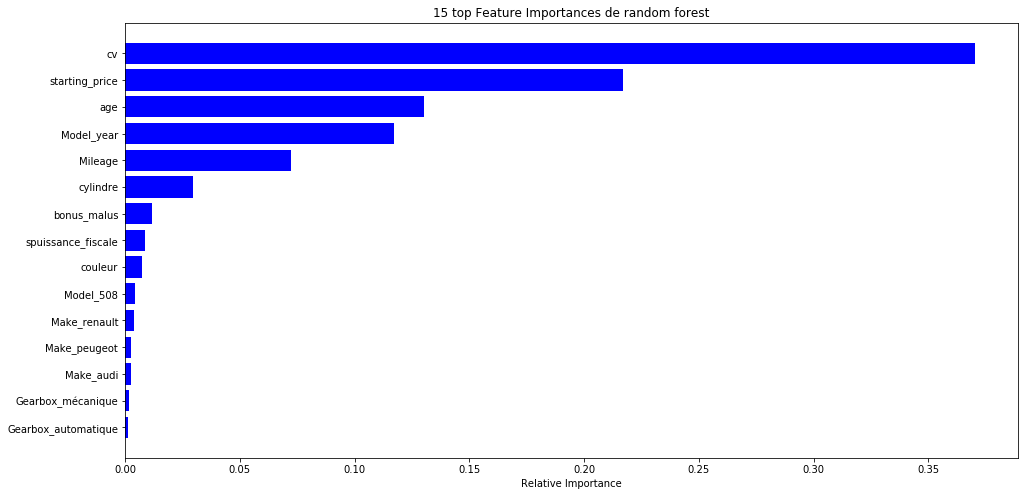

In [24]:
features = X_train.columns
importances = rfr.feature_importances_
indices = np.argsort(importances)
#print(indices[:15])
#print(sorted(importances))

plt.figure(figsize=(16,8))
plt.title('15 top Feature Importances de random forest')
plt.barh(range(len(indices))[-15:], importances[indices][-15:], color='b', align='center')
plt.yticks(range(len(indices))[-15:], [features[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
#plt.show()

In [66]:
%%time
scores = []
mapes = []

cv = KFold(n_splits=20, shuffle=False)

for train_index, val_index in cv.split(X_train):

    X_train_cv, X_val, y_train_cv, y_val = X_train.iloc[train_index, :], \
                                            X_train.iloc[val_index, :], \
                                            y_train[train_index], y_train[val_index]
    # model
    rf_cv = RandomForestRegressor(verbose=-1, n_jobs=-1)
    # fit
    rf_cv.fit(X_train_cv, y_train_cv)
    y_val_pred = rf_cv.predict(X_val)
    # add score
    scores.append(accuracy_score(y_val, y_val_pred))
    # metric mape
    mapes.append(MAPE(y_val, y_val_pred))

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.5s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_j

CPU times: user 10min 16s, sys: 16.2 s, total: 10min 32s
Wall time: 3min 43s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


(0, 1)

Text(0, 0.5, 'scores')

Text(0.5, 0, 'Fold')

Text(0.5, 1.0, 'Score of Cross Validation with 20 Folder on Random Forest')

Text(0, 0.5, 'MAPE')

Text(0.5, 0, 'Fold')

(0, 1)

Text(0.5, 1.0, 'MAPE of Cross Validation with 20 Folder on Random Forest')

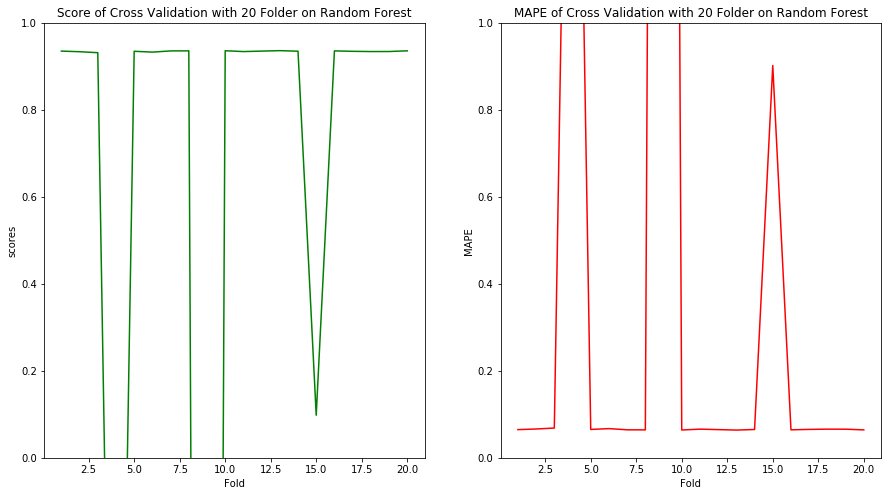

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax = ax.flatten()
ax[0].plot(range(1,21,1), scores, 'g-')
ax[0].set_ylim([0,1])
ax[0].set_ylabel("scores")
ax[0].set_xlabel("Fold")
ax[0].set_title("Score of Cross Validation with 20 Folder on Random Forest")
ax[1].plot(range(1,21,1), mapes, 'r-')
ax[1].set_ylabel("MAPE")
ax[1].set_xlabel("Fold")
ax[1].set_ylim([0,1])
ax[1].set_title("MAPE of Cross Validation with 20 Folder on Random Forest")
plt.show()

## Avec hyperparameter

In [68]:
best_param_cv = {
    'bootstrap': True,
    'max_depth': 80,
    'max_features': 2,
    'min_samples_split': 8,
    'min_samples_leaf': 3,
    'n_estimators': 100
}
rfr = RandomForestRegressor(**best_param_cv)
rfr.fit(X_train, y_train)
evaluate(rfr, X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 69.89%.
MAPE = 30.11%.


69.89010151778612

In [69]:
best_param_cv = {
    'bootstrap': True,
    'max_depth': 80,
    'max_features': 2,
    'min_samples_split': 8,
    'min_samples_leaf': 3,
    'n_estimators': 100
}
rfr = RandomForestRegressor(**best_param_cv)
rfr.fit(X_train, y_train)
evaluate(rfr, X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 71.14%.
MAPE = 28.86%.


71.13726529161865

In [70]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
evaluate(rfr, X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.70%.
MAPE = 6.30%.


93.69587385285247

In [73]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)
    evaluate(rfr, X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.65%.
MAPE = 6.35%.


93.65473340832368

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.73%.
MAPE = 6.27%.


93.72790531828414

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.76%.
MAPE = 6.24%.


93.7617594040848

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.66%.
MAPE = 6.34%.


93.65669817978097

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.77%.
MAPE = 6.23%.


93.77256068040977

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.63%.
MAPE = 6.37%.


93.63066041993505

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.69%.
MAPE = 6.31%.


93.69277939271876

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.67%.
MAPE = 6.33%.


93.67391226882778

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.76%.
MAPE = 6.24%.


93.75915695886815

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 93.74%.
MAPE = 6.26%.


93.73716618534392

## Avec Hyperparameter

In [158]:
best_param_cv = {
    'bootstrap': True,
    'max_depth': 50,
    'max_features': 5,
    'min_samples_split': 8,
    'min_samples_leaf': 5,
    'n_estimators': 100
}

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
    rfr = RandomForestRegressor(**best_param_cv)
    rfr.fit(X_train, y_train)
    evaluate(rfr, X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 74.61%.
MAPE = 25.39%.


74.60598431142786

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 75.05%.
MAPE = 24.95%.


75.04791970315841

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 74.49%.
MAPE = 25.51%.


74.49476213857989

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 73.86%.
MAPE = 26.14%.


73.8583881968411

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 74.99%.
MAPE = 25.01%.


74.99066924115155

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 74.32%.
MAPE = 25.68%.


74.31942789129369

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 74.78%.
MAPE = 25.22%.


74.77636847795127

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 75.31%.
MAPE = 24.69%.


75.30853814440431

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 75.44%.
MAPE = 24.56%.


75.43693812755609

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 75.14%.
MAPE = 24.86%.


75.13533517626364

## LightGBM

In [77]:
import lightgbm as lgb

In [78]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [79]:
train_data = lgb.Dataset(X_train_.values, label=y_train_)
validation_data = lgb.Dataset(X_val.values, label=y_val, reference=train_data)

In [115]:
param = {
    'num_leaves': 31,
    'objective': 'regression',
    'metric': 'mape',
    'max_depth': 15, 
    'learning_rate': 0.05,
    'verbose': 0, 
    'early_stopping_round': 500,
    'max_bin': 500
}
evals_result = {}

In [116]:
num_round = 20000
bst = lgb.train(param,
                train_data,
                num_round,
                valid_sets=[train_data, validation_data],
                evals_result=evals_result,
                verbose_eval=500)

Training until validation scores don't improve for 500 rounds.
[500]	training's mape: 0.637271	valid_1's mape: 0.0700989
[1000]	training's mape: 0.533398	valid_1's mape: 0.0659158
[1500]	training's mape: 0.467871	valid_1's mape: 0.0640653
[2000]	training's mape: 0.418239	valid_1's mape: 0.0627711
[2500]	training's mape: 0.377002	valid_1's mape: 0.0618671
[3000]	training's mape: 0.345161	valid_1's mape: 0.061233
[3500]	training's mape: 0.305785	valid_1's mape: 0.0608356
[4000]	training's mape: 0.284013	valid_1's mape: 0.0604987
[4500]	training's mape: 0.262604	valid_1's mape: 0.0602738
[5000]	training's mape: 0.243814	valid_1's mape: 0.0600986
[5500]	training's mape: 0.230969	valid_1's mape: 0.0599439
[6000]	training's mape: 0.222919	valid_1's mape: 0.0598437
[6500]	training's mape: 0.215031	valid_1's mape: 0.0597247
[7000]	training's mape: 0.208061	valid_1's mape: 0.059604
[7500]	training's mape: 0.20139	valid_1's mape: 0.0595326
[8000]	training's mape: 0.193163	valid_1's mape: 0.05946

Plotting metrics recorded during training...


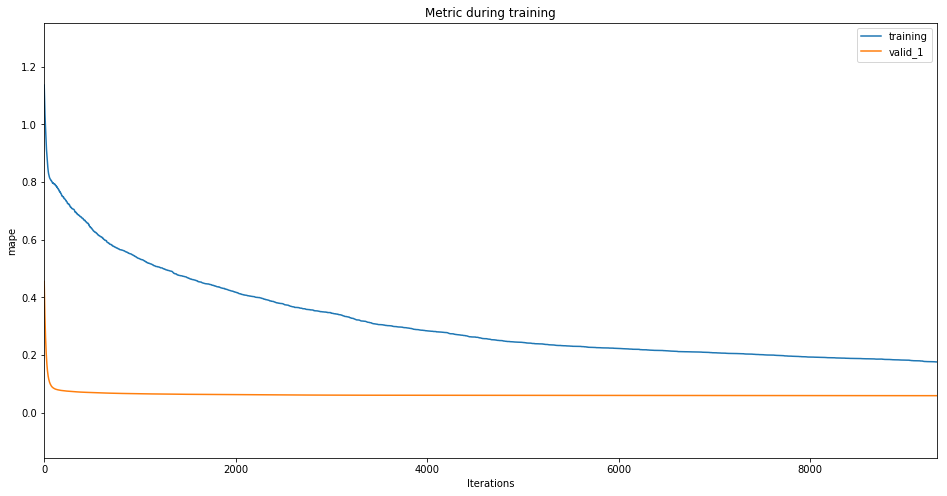

In [117]:
print('Plotting metrics recorded during training...')
lgb.plot_metric(evals_result, metric='mape', grid=False, figsize=(16,8))
#plt.show()

In [120]:
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
print("Model performance: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("MAPE: {:.2f}%".format(MAPE(y_test, y_pred) * 100))

Model performance: 94.02%
MAPE: 5.98%


In [141]:
numeric_features = ["cylindre", "cv", "age", "Model_year", "Mileage",
                    "spuissance_fiscale", "starting_price", "bunus_malus"]
cat_features = list(set(list(X_train.columns)).difference(set(numeric_features)))

In [135]:
train_data = lgb.Dataset(X_train_.values,
                         label=y_train_,
                         feature_name=list(X_train.columns),
                         categorical_feature=cat_features)
validation_data = lgb.Dataset(X_val.values,
                              label=y_val,
                              reference=train_data,
                              feature_name=list(X_train.columns),
                              categorical_feature=cat_features)

In [136]:
param_ = {
    'num_leaves': 31,
    'objective': 'regression',
    'metric': 'mape',
    'max_depth': 15, 
    'learning_rate': 0.05,
    'verbose': 0, 
    'early_stopping_round': 500,
    'max_bin': 500
}
evals_result_ = {}

In [137]:
num_round = 20000
bst_ = lgb.train(param_,
                train_data,
                num_round,
                valid_sets=[train_data, validation_data],
                evals_result=evals_result_,
                verbose_eval=500)

Training until validation scores don't improve for 500 rounds.
[500]	training's mape: 0.560207	valid_1's mape: 0.0700143
[1000]	training's mape: 0.435364	valid_1's mape: 0.066902
[1500]	training's mape: 0.368846	valid_1's mape: 0.0653501
[2000]	training's mape: 0.324152	valid_1's mape: 0.0643378
[2500]	training's mape: 0.291464	valid_1's mape: 0.0635783
[3000]	training's mape: 0.263043	valid_1's mape: 0.0631058
[3500]	training's mape: 0.237028	valid_1's mape: 0.0626693
[4000]	training's mape: 0.215472	valid_1's mape: 0.0624073
[4500]	training's mape: 0.197349	valid_1's mape: 0.0621257
[5000]	training's mape: 0.183757	valid_1's mape: 0.0619566
[5500]	training's mape: 0.174212	valid_1's mape: 0.0618381
[6000]	training's mape: 0.167158	valid_1's mape: 0.0617243
[6500]	training's mape: 0.15908	valid_1's mape: 0.0616228
[7000]	training's mape: 0.15149	valid_1's mape: 0.061532
[7500]	training's mape: 0.143037	valid_1's mape: 0.0614343
[8000]	training's mape: 0.13711	valid_1's mape: 0.0613981

Plotting metrics recorded during training...


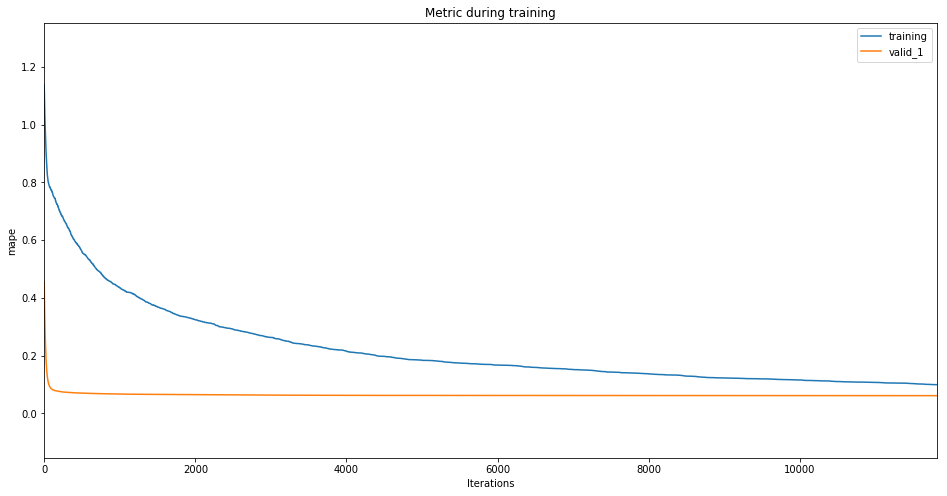

In [139]:
print('Plotting metrics recorded during training...')
lgb.plot_metric(evals_result_, metric='mape', grid=False, figsize=(16,8))

In [140]:
y_pred = bst.predict(X_test, num_iteration=bst_.best_iteration)
print("Model performance: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("MAPE: {:.2f}%".format(MAPE(y_test, y_pred) * 100))

Model performance: 94.02%
MAPE: 5.98%


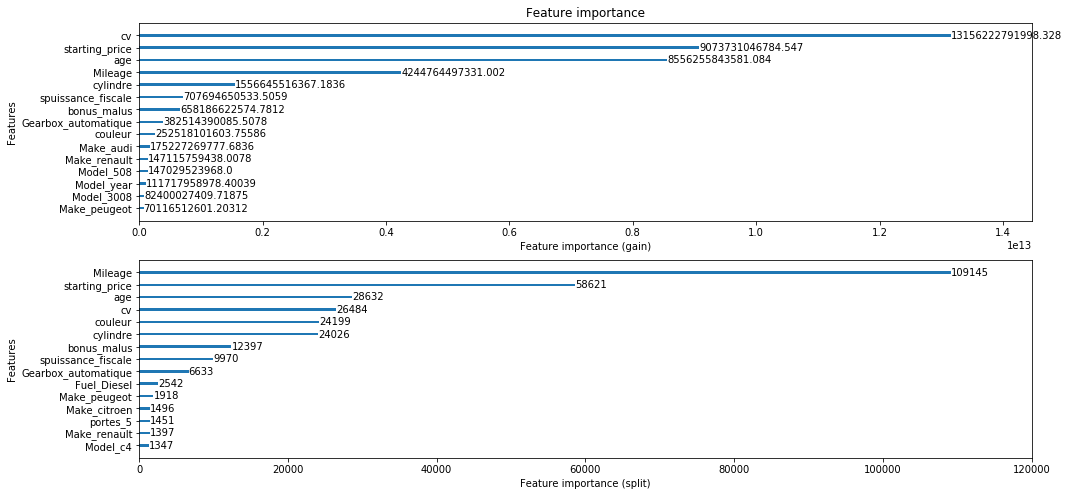

In [151]:
fig, ax = plt.subplots(2,1, figsize=(16,8))
ax=ax.flatten()
lgb.plot_importance(bst_, title="Feature importance", xlabel="Feature importance (gain)",
                    importance_type="gain",
                    max_num_features=15,
                    figsize=(16,8),
                    grid=False,
                    ax=ax[0])
lgb.plot_importance(bst_, title=None, xlabel="Feature importance (split)",
                    importance_type="split",
                    max_num_features=15,
                    figsize=(16,8),
                    grid=False,
                    ax=ax[1])

In [154]:
cv_results = lgb.cv(param,
                    train_data,
                    5000,
                    feature_name=list(X_train.columns),
                    categorical_feature=cat_features,
                    nfold=5,
                    stratified=False)

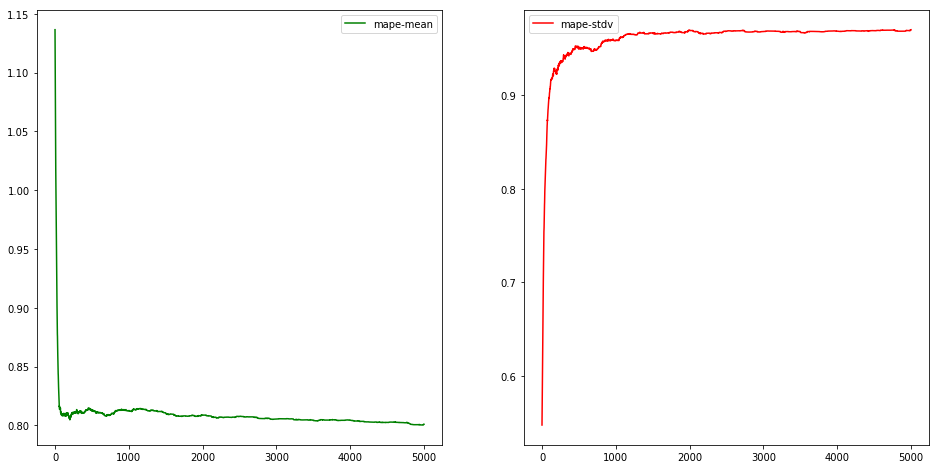

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax = ax.flatten()
ax[0].plot(range(len(cv_results['mape-mean'])), cv_results['mape-mean'], color='green', label='mape-mean')
ax[1].plot(range(len(cv_results['mape-stdv'])), cv_results['mape-stdv'], color='red', label='mape-stdv')
ax[0].legend()
ax[1].legend()

## Analyst

In [160]:
data.head()

,couleur,cylindre,cv,age,Model_year,Mileage,spuissance_fiscale,starting_price,bonus_malus,Make_abarth,Make_aixam,Make_alfa romeo,Make_audi,Make_bellier,Make_bmw,Make_bollore,Make_cadillac,Make_caterham,Make_chatenet,Make_chevrolet,Make_chrysler,Make_citroen,Make_dacia,Make_daewoo,Make_daihatsu,Make_dangel,Make_dodge,Make_ds,Make_fiat,Make_ford,Make_grecav,Make_honda,Make_hummer,Make_hyundai,Make_infiniti,Make_jaguar,Make_jeep,Make_jiayuan,Make_kia,Make_lada,Make_lancia,Make_land rover,Make_lexus,Make_ligier,Make_lotus,Make_maserati,Make_mazda,Make_mercedes,Make_mg,Make_mia electric,Make_microcar,Make_mini,Make_mitsubishi,Make_morgan,Make_mpm motors,Make_nissan,Make_opel,Make_peugeot,Make_porsche,Make_renault,Make_rover,Make_saab,Make_seat,Make_secma,Make_skoda,Make_smart,Make_ssangyong,Make_subaru,Make_suzuki,Make_toyota,Make_volkswagen,Make_volvo,Model_1007,Model_106,Model_107,Model_108,Model_124,Model_126,Model_130,Model_147,Model_156,Model_159,Model_160,Model_166,Model_180,Model_2,Model_200,Model_2008,Model_206,Model_206+,Model_207,Model_207+,Model_208,Model_25,Model_3,Model_3.0,Model_300 c,Model_3008,Model_306,Model_307,Model_308,Model_350z,Model_370z,Model_4/4,Model_4007,Model_4008,Model_406,Model_407,Model_45,Model_5,Model_500,Model_500 l,Model_500 x,Model_5008,Model_508,Model_508 rxh,Model_6,Model_607,Model_626,Model_75,Model_80,Model_806,Model_807,Model_9-3,Model_9-5,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a7,Model_a721,Model_a8,Model_accent,Model_accord,Model_actyon,Model_adam,Model_agila,Model_alhambra,Model_almera,Model_almera tino,Model_altea,Model_altea freetrack,Model_alto,Model_antara,Model_arona,Model_arosa,Model_arteon,Model_astra,Model_asx,Model_ateca,Model_atos,Model_atos prime,Model_auris,Model_avantime,Model_avenger,Model_avensis,Model_avensis verso,Model_aveo,Model_aygo,Model_b-max,Model_b8,Model_baleno,Model_berlingo,Model_bipper tepee,Model_bluecar,Model_bluesummer,Model_bora,Model_boxster,Model_bravo,Model_brera,Model_brz,Model_c-crosser,Model_c-elysee,Model_c-hr,Model_c-max,Model_c-zero,Model_c1,Model_c15,Model_c2,Model_c25,Model_c3,Model_c30,Model_c4,Model_c5,Model_c6,Model_c70,Model_c8,Model_cabstar,Model_caddy,Model_caliber,Model_captiva,Model_captur,Model_carens,Model_carnival,Model_cascada,Model_cayenne,Model_cayman,Model_cc,Model_cee d,Model_celerio,Model_cerato,Model_ch 26,Model_ch 40,Model_challenger,Model_cherokee,Model_citan,Model_citigo,Model_city,Model_city fun,Model_civic,Model_cl,Model_cla,Model_classe a,Model_classe b,Model_classe c,Model_classe clc,Model_classe cls,Model_classe e,Model_classe g,Model_classe gl,Model_classe glk,Model_classe m,Model_classe r,Model_classe s,Model_classe v,Model_clio,Model_clk,Model_coccinelle,Model_colt,Model_combo,Model_commander,Model_compass,Model_copen,Model_cordoba,Model_corolla,Model_corolla verso,Model_corsa,Model_corvette,Model_cougar,Model_countryman,Model_coupe,Model_cr-v,Model_cr-z,Model_croma,Model_crossblade,Model_crossfire,Model_crossland x,Model_crossline,Model_crossover,Model_cruze,Model_ct,Model_cts,Model_cube,Model_custom,Model_cx-3,Model_cx-5,Model_cx-7,Model_cx-9,Model_daimler,Model_defender,Model_delta,Model_discovery,Model_discovery sport,Model_doblo,Model_dokker,Model_ds 3,Model_ds 4,Model_ds 4 crossback,Model_ds 5,Model_ds 7 crossback,Model_ds3,Model_ds4,Model_ds5,Model_due,Model_duster,Model_e-mehari,Model_eclipse cross,Model_ecosport,Model_edge,Model_eke,Model_elise,Model_eos,Model_epica,Model_espace,Model_evalia,Model_evasion,Model_ex,Model_exeo,Model_expert tepee,Model_f,Model_f-16,Model_f-pace,Model_fabia,Model_fiesta,Model_fiorino,Model_flavia,Model_fluence,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_fr-v,Model_freelander,Model_freemont,Model_frontera,Model_fusion,Model_fx,Model_g,Model_galaxy,Model_galloper,Model_genesis,Model_getz,Model_ghibli,Model_giulia,Model_giulietta,Model_gla,Model_glc,Model_gmc,Model_golf,Model_golf plus,Model_golf sportsvan,Model_grand c-max,Mo

In [163]:
data.shape

(115031, 695)

In [162]:
target.shape

(115031,)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [203]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
evaluate(rfr, X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model Performance
Accuracy = 97.52%.
MAPE = 2.48%.


97.51700715823229

In [167]:
evaluate(rfr, X_test, y_test)

Model Performance
Accuracy = 93.68%.
MAPE = 6.32%.


93.67766268913078

les 15 echantillons qui ont le plus erreur

In [204]:
y_pred_train = rfr.predict(X_train)
MAPE(y_train, y_pred_train)*100

2.510304948818343

In [205]:
error_train = np.abs(y_pred_train - y_train)

In [206]:
indices = np.argsort(error_train)

In [207]:
error_train[indices[-15:]]

array([4834.2       , 4837.8       , 4846.9       , 4862.7       ,
       4952.7       , 4980.32493447, 5058.8       , 5125.5       ,
       5149.5       , 5150.3       , 5264.3       , 5564.5       ,
       5717.9       , 5888.2       , 9148.5       ])

In [208]:
X_train.reset_index().iloc[indices[-15:],:]

,index,couleur,cylindre,cv,age,Model_year,Mileage,spuissance_fiscale,starting_price,bonus_malus,Make_abarth,Make_aixam,Make_alfa romeo,Make_audi,Make_bellier,Make_bmw,Make_bollore,Make_cadillac,Make_caterham,Make_chatenet,Make_chevrolet,Make_chrysler,Make_citroen,Make_dacia,Make_daewoo,Make_daihatsu,Make_dangel,Make_dodge,Make_ds,Make_fiat,Make_ford,Make_grecav,Make_honda,Make_hummer,Make_hyundai,Make_infiniti,Make_jaguar,Make_jeep,Make_jiayuan,Make_kia,Make_lada,Make_lancia,Make_land rover,Make_lexus,Make_ligier,Make_lotus,Make_maserati,Make_mazda,Make_mercedes,Make_mg,Make_mia electric,Make_microcar,Make_mini,Make_mitsubishi,Make_morgan,Make_mpm motors,Make_nissan,Make_opel,Make_peugeot,Make_porsche,Make_renault,Make_rover,Make_saab,Make_seat,Make_secma,Make_skoda,Make_smart,Make_ssangyong,Make_subaru,Make_suzuki,Make_toyota,Make_volkswagen,Make_volvo,Model_1007,Model_106,Model_107,Model_108,Model_124,Model_126,Model_130,Model_147,Model_156,Model_159,Model_160,Model_166,Model_180,Model_2,Model_200,Model_2008,Model_206,Model_206+,Model_207,Model_207+,Model_208,Model_25,Model_3,Model_3.0,Model_300 c,Model_3008,Model_306,Model_307,Model_308,Model_350z,Model_370z,Model_4/4,Model_4007,Model_4008,Model_406,Model_407,Model_45,Model_5,Model_500,Model_500 l,Model_500 x,Model_5008,Model_508,Model_508 rxh,Model_6,Model_607,Model_626,Model_75,Model_80,Model_806,Model_807,Model_9-3,Model_9-5,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a7,Model_a721,Model_a8,Model_accent,Model_accord,Model_actyon,Model_adam,Model_agila,Model_alhambra,Model_almera,Model_almera tino,Model_altea,Model_altea freetrack,Model_alto,Model_antara,Model_arona,Model_arosa,Model_arteon,Model_astra,Model_asx,Model_ateca,Model_atos,Model_atos prime,Model_auris,Model_avantime,Model_avenger,Model_avensis,Model_avensis verso,Model_aveo,Model_aygo,Model_b-max,Model_b8,Model_baleno,Model_berlingo,Model_bipper tepee,Model_bluecar,Model_bluesummer,Model_bora,Model_boxster,Model_bravo,Model_brera,Model_brz,Model_c-crosser,Model_c-elysee,Model_c-hr,Model_c-max,Model_c-zero,Model_c1,Model_c15,Model_c2,Model_c25,Model_c3,Model_c30,Model_c4,Model_c5,Model_c6,Model_c70,Model_c8,Model_cabstar,Model_caddy,Model_caliber,Model_captiva,Model_captur,Model_carens,Model_carnival,Model_cascada,Model_cayenne,Model_cayman,Model_cc,Model_cee d,Model_celerio,Model_cerato,Model_ch 26,Model_ch 40,Model_challenger,Model_cherokee,Model_citan,Model_citigo,Model_city,Model_city fun,Model_civic,Model_cl,Model_cla,Model_classe a,Model_classe b,Model_classe c,Model_classe clc,Model_classe cls,Model_classe e,Model_classe g,Model_classe gl,Model_classe glk,Model_classe m,Model_classe r,Model_classe s,Model_classe v,Model_clio,Model_clk,Model_coccinelle,Model_colt,Model_combo,Model_commander,Model_compass,Model_copen,Model_cordoba,Model_corolla,Model_corolla verso,Model_corsa,Model_corvette,Model_cougar,Model_countryman,Model_coupe,Model_cr-v,Model_cr-z,Model_croma,Model_crossblade,Model_crossfire,Model_crossland x,Model_crossline,Model_crossover,Model_cruze,Model_ct,Model_cts,Model_cube,Model_custom,Model_cx-3,Model_cx-5,Model_cx-7,Model_cx-9,Model_daimler,Model_defender,Model_delta,Model_discovery,Model_discovery sport,Model_doblo,Model_dokker,Model_ds 3,Model_ds 4,Model_ds 4 crossback,Model_ds 5,Model_ds 7 crossback,Model_ds3,Model_ds4,Model_ds5,Model_due,Model_duster,Model_e-mehari,Model_eclipse cross,Model_ecosport,Model_edge,Model_eke,Model_elise,Model_eos,Model_epica,Model_espace,Model_evalia,Model_evasion,Model_ex,Model_exeo,Model_expert tepee,Model_f,Model_f-16,Model_f-pace,Model_fabia,Model_fiesta,Model_fiorino,Model_flavia,Model_fluence,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_fr-v,Model_freelander,Model_freemont,Model_frontera,Model_fusion,Model_fx,Model_g,Model_galaxy,Model_galloper,Model_genesis,Model_getz,Model_ghibli,Model_giulia,Model_giulietta,Model_gla,Model_glc,Model_gmc,Model_golf,Model_golf plus,Model_golf sportsvan,Model_grand c-

In [209]:
pd.DataFrame(y_train[indices[-15:]], index=indices[-15:]).values

array([[15990.],
       [29780.],
       [25315.],
       [16086.],
       [19170.],
       [21413.],
       [21699.],
       [17029.],
       [24665.],
       [12173.],
       [27233.],
       [29691.],
       [27626.],
       [ 7301.],
       [27198.]])

In [179]:
y_

array([1., 1., 1.])

In [180]:
target

array([11220.,  2830., 12925., ..., 20990., 12056., 13423.])

In [191]:
data_norm = data[(data.Price <= 30000) & (data.Price > 5000)]

In [192]:
#target = np.log(data["Price"].values)
target = data_norm["Price"].values
data = data_norm.drop(["Price"], axis=1)

In [193]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((84414, 695), (21104, 695), (84414,), (21104,))

### Model RandomForest sans hyperparameter

In [194]:
rfr = RandomForestRegressor(random_state=2)
rfr.fit(X_train, y_train)
evaluate(rfr, X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

Model Performance
Accuracy = 94.03%.
MAPE = 5.97%.


94.02600084545934

In [195]:
evaluate(rfr, X_train, y_train)

Model Performance
Accuracy = 97.50%.
MAPE = 2.50%.


97.50282084942545

In [196]:
evaluate(rfr, data, target)

Model Performance
Accuracy = 96.81%.
MAPE = 3.19%.


96.807443668625

In [198]:
%%time
scores = []
mapes = []

cv = KFold(n_splits=20, shuffle=False)

for train_index, val_index in cv.split(X_train):

    X_train_cv, X_val, y_train_cv, y_val = X_train.iloc[train_index, :], \
                                            X_train.iloc[val_index, :], \
                                            y_train[train_index], y_train[val_index]
    # model
    rf_cv = RandomForestRegressor(verbose=-1, n_jobs=-1)
    # fit
    rf_cv.fit(X_train_cv, y_train_cv)
    y_val_pred = rf_cv.predict(X_val)
    # add score
    scores.append(accuracy_score(y_val, y_val_pred))
    # metric mape
    mapes.append(MAPE(y_val, y_val_pred))

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_j

CPU times: user 10min 6s, sys: 26.7 s, total: 10min 32s
Wall time: 5min 58s


(0, 1)

Text(0, 0.5, 'scores')

Text(0.5, 0, 'Fold')

Text(0.5, 1.0, 'Score of Cross Validation with 20 Folder on Random Forest')

Text(0, 0.5, 'MAPE')

Text(0.5, 0, 'Fold')

(0, 1)

Text(0.5, 1.0, 'MAPE of Cross Validation with 20 Folder on Random Forest')

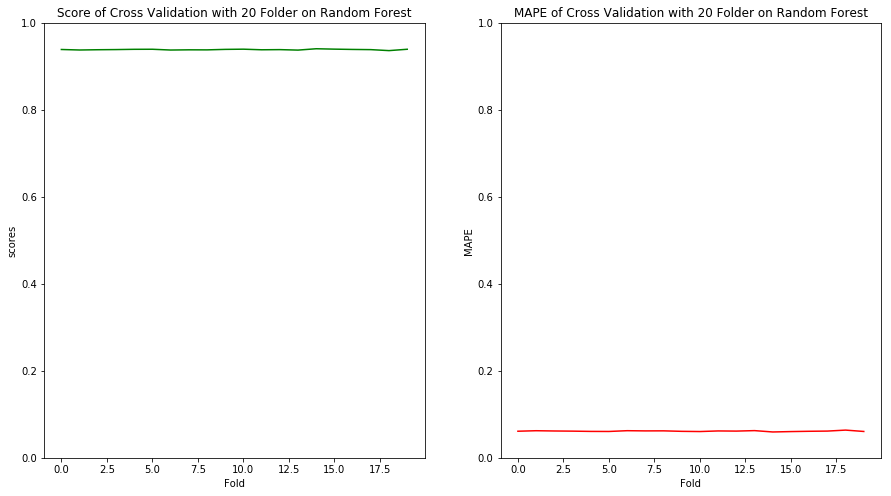

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax = ax.flatten()
ax[0].plot(range(len(scores)), scores, 'g-')
ax[0].set_ylim([0,1])
ax[0].set_ylabel("scores")
ax[0].set_xlabel("Fold")
ax[0].set_title("Score of Cross Validation with {} Folder on Random Forest".format(len(scores)))
ax[1].plot(range(len(mapes)), mapes, 'r-')
ax[1].set_ylabel("MAPE")
ax[1].set_xlabel("Fold")
ax[1].set_ylim([0,1])
ax[1].set_title("MAPE of Cross Validation with {} Folder on Random Forest".format(len(mapes)))
plt.show()

In [214]:
scores

[0.9388926496676497,
 0.9377381931204,
 0.9383408698586931,
 0.9386997975476422,
 0.9393105834889126,
 0.9394409280961831,
 0.9376603378855827,
 0.9381386584129797,
 0.9380280023044916,
 0.9391528985639885,
 0.9396086719023019,
 0.938237468799998,
 0.9385941680575637,
 0.9375045482148575,
 0.9406046868965635,
 0.9396931875471622,
 0.9390245036572188,
 0.9385751719288294,
 0.9363133652393354,
 0.9394378355864428]

In [216]:
np.mean(mapes)

0.061350173661160176